# Advanced Lane Finding Steps

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Create a video using the output images.

In [1]:
# Necessary imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Camera calibration

In [2]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./pdata/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [3]:
# Helper function to show Image
def show_image(image, figsize=(15,10), cmap=None):  
    plt.figure(figsize=(10, 11))
    plt.subplot(rows, cols, 1)
    cmap = 'gray' if len(image.shape)==2 else cmap
    plt.imshow(image, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
            
def show_images(images, cols = 2, rows = 2, figsize=(15,15), cmap = None):
    imageLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imageLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(imagePathName)

## Apply a distortion correction to raw images

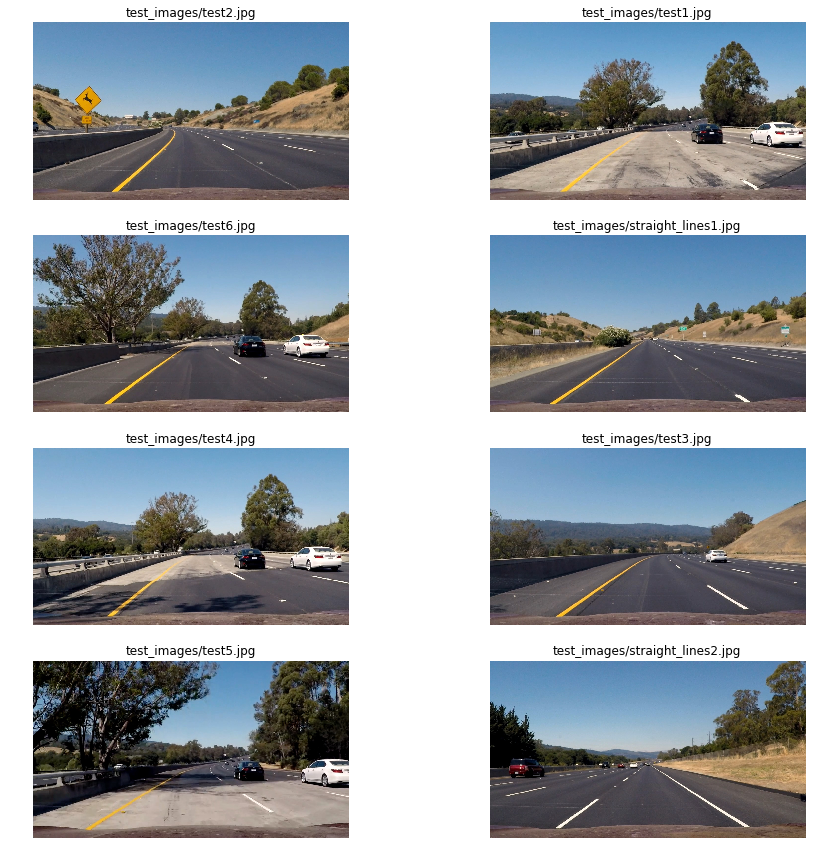

In [4]:
# Load images and show original test images
# Load with OpenCV (BGR format)
test_images = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('test_images/*.jpg')))

# List map with using lambda functions
# http://www.u.arizona.edu/~erdmann/mse350/topics/list_comprehensions.html
show_images(list(map(lambda image: (image[0], cv2.cvtColor(image[1], cv2.COLOR_BGR2RGB)),test_images)), 2, 4, (15, 15))

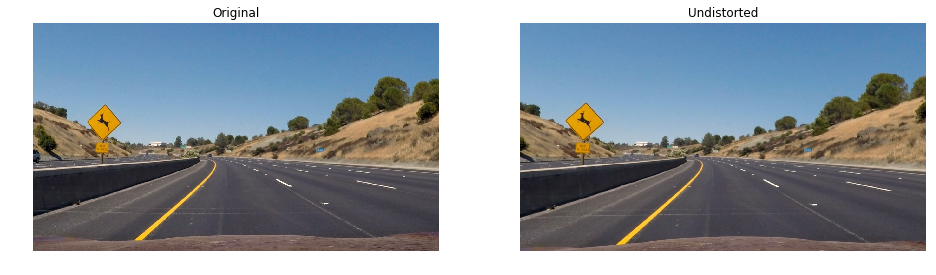

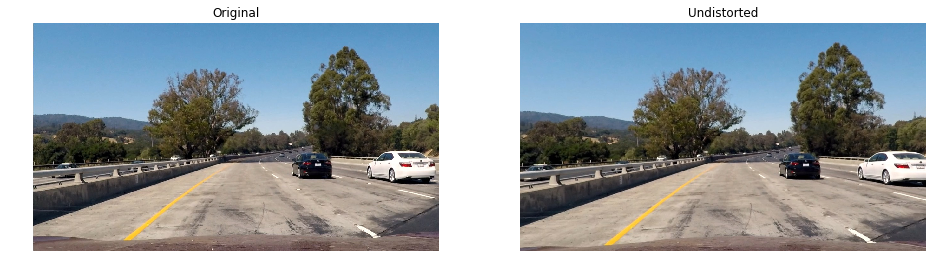

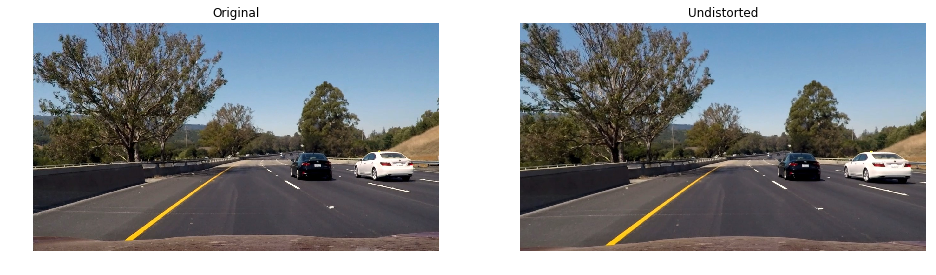

In [5]:
# Show original and undistorted image side by side
def show_compare_images(leftImg, leftTitle, rightImg, rightTitle, figsize=(16,10), cmap=None):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    if cmap == None:
        axes[0].imshow(leftImg)
    else:
        axes[0].imshow(leftImg, cmap=cmap)
    axes[0].set_title(leftTitle)
    axes[0].axis('off')
    if cmap == None:
        axes[1].imshow(rightImg)
    else:
        axes[1].imshow(rightImg, cmap=cmap)
    axes[1].set_title(rightTitle)
    axes[1].axis('off')

for original in test_images[:3]:
    show_compare_images(
        cv2.cvtColor(original[1], cv2.COLOR_BGR2RGB), 'Original',
        cv2.cvtColor(cv2.undistort(original[1], mtx, dist, None, mtx), cv2.COLOR_BGR2RGB), 'Undistorted'
    )

## Change color spaces, isolate color channel and combine with gradients.

In [6]:
# Helper functions for list / map / lambda
def applyActionToImages(images, action):
    # Apply an action to test images
    return list(map(lambda image: (image[0], action(image[1])), images))

# Undistort BGR image
def undistort_image(image, mtx=mtx, dist=dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

# Undistort image and convert to HLS colorspace
def undistort_image_and_convert_to_HLS(image, mtx=mtx, dist=dist):
    ouput = undistort_image(image, mtx, dist)
    return cv2.cvtColor(ouput, cv2.COLOR_BGR2HLS)

# Undistort image and convert to HSV colorspace
def undistort_image_and_convert_to_HSV(image, mtx=mtx, dist=dist):
    ouput = undistort_image(image, mtx, dist)
    return cv2.cvtColor(ouput, cv2.COLOR_BGR2HSV)

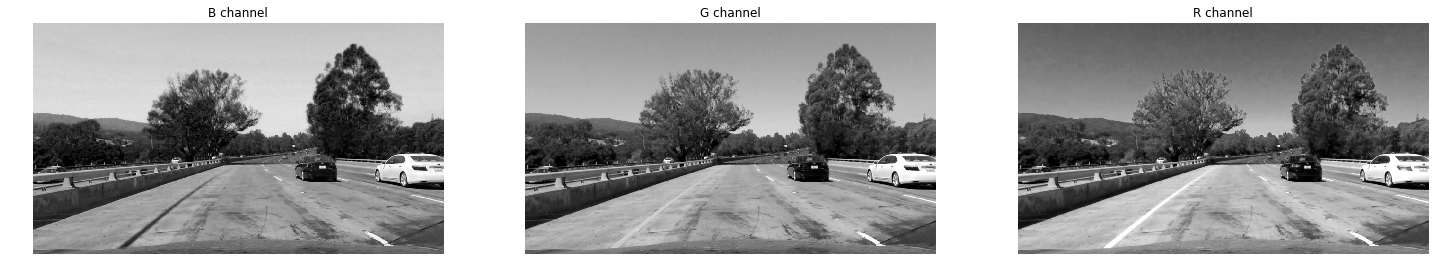

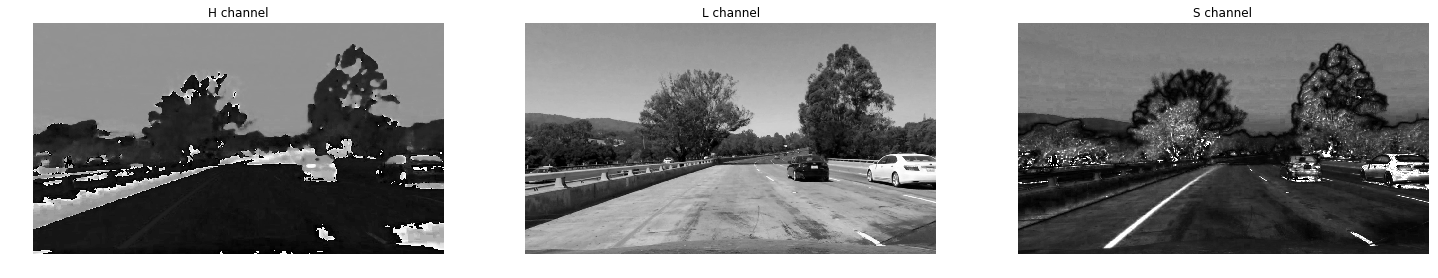

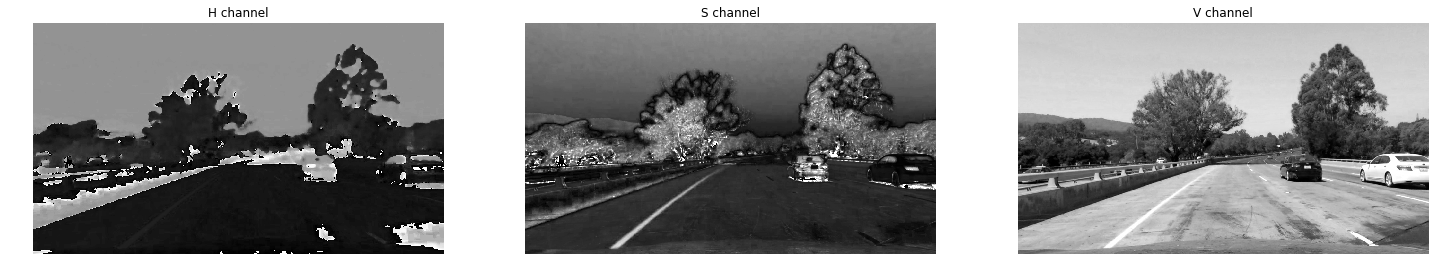

In [7]:
original = test_images[1][1]

# BGR Color channel
labels = ['B channel', 'G channel', 'R channel']
bgr_original = undistort_image(original)
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, a in enumerate(axes):
    a.imshow(bgr_original[:,:,index], cmap='gray')
    a.axis('off')
    a.set_title(labels[index])
    cv2.imwrite('images/example_BGR_' + labels[index] + '.png', bgr_original[:,:,index])

# HLS Color channel
labels = ['H channel', 'L channel', 'S channel']
hls_original = undistort_image_and_convert_to_HLS(original)
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, a in enumerate(axes):
    a.imshow(hls_original[:,:,index], cmap='gray')
    a.axis('off')
    a.set_title(labels[index])
    cv2.imwrite('images/example_HLS_' + labels[index] + '.png', hls_original[:,:,index])
    
# HSV Color channel
labels = ['H channel', 'S channel', 'V channel']
hsv_original = undistort_image_and_convert_to_HSV(original)
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, a in enumerate(axes):
    a.imshow(hsv_original[:,:,index], cmap='gray')
    a.axis('off')
    a.set_title(labels[index])
    cv2.imwrite('images/example_HSV_' + labels[index] + '.png', hsv_original[:,:,index])

From all channels above, S channel is the one that performed better detecting lane lines, even in the shadows.

### Use Sobel transform (core function to Canny Edge)

In [8]:
s_channel = lambda image: undistort_image_and_convert_to_HLS(image)[:,:,2]

# Applies a threshold and return binary image
def ApplyThreshold(img, thresh_min, thresh_max):
    binary = np.zeros_like(img)
    binary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary

# Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return ApplyThreshold(scaled, thresh_min, thresh_max)

In [9]:
# Define lambda sobels
action_sobel_X = lambda img: abs_sobel_thresh(s_channel(img), thresh_min=10, thresh_max=160)
action_sobel_Y = lambda img: abs_sobel_thresh(s_channel(img), orient='y', thresh_min=10, thresh_max=160)

### Combine color channel and Sobel

In [10]:
# Combine Sobel X and Y
def combineGradients(img):
    sobel_x = action_sobel_X(img)
    sobel_y = action_sobel_Y(img)
    combined = np.zeros_like(sobel_x) 
    combined[((sobel_x == 1) & (sobel_y == 1))] = 1
    return combined

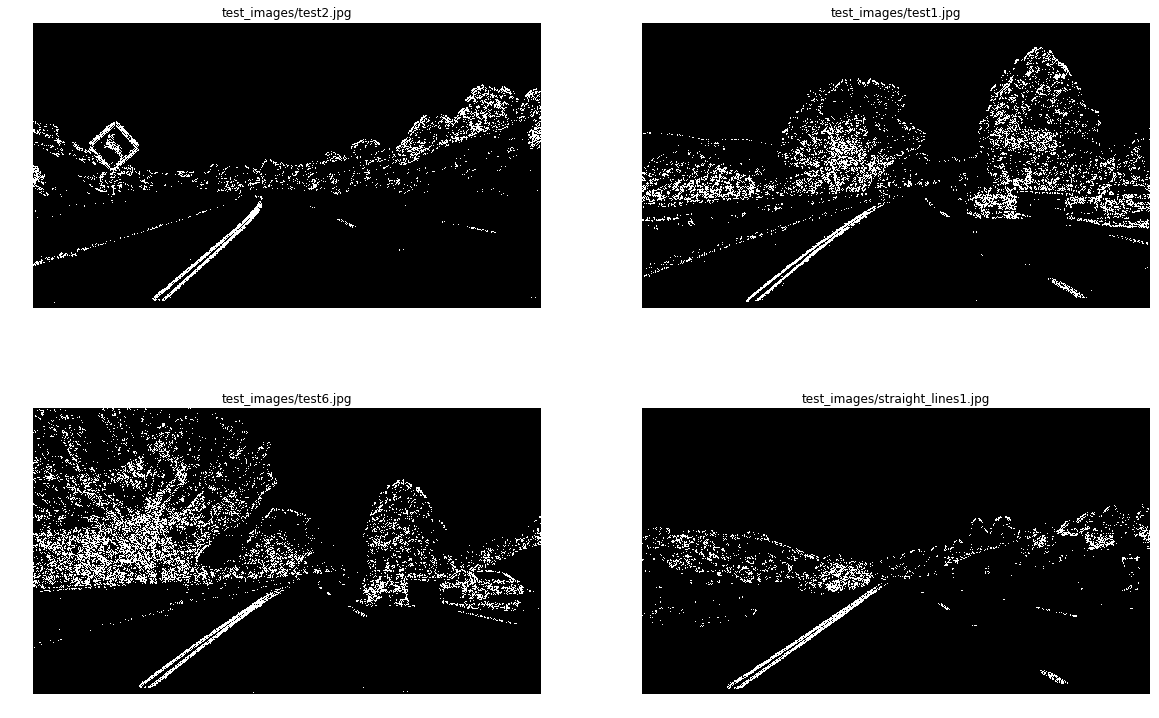

In [11]:
resultCombined = applyActionToImages(test_images, combineGradients)
show_images(resultCombined, 2, 2, (20, 13), cmap='gray')

## Apply a perspective transform ("bird eye view")

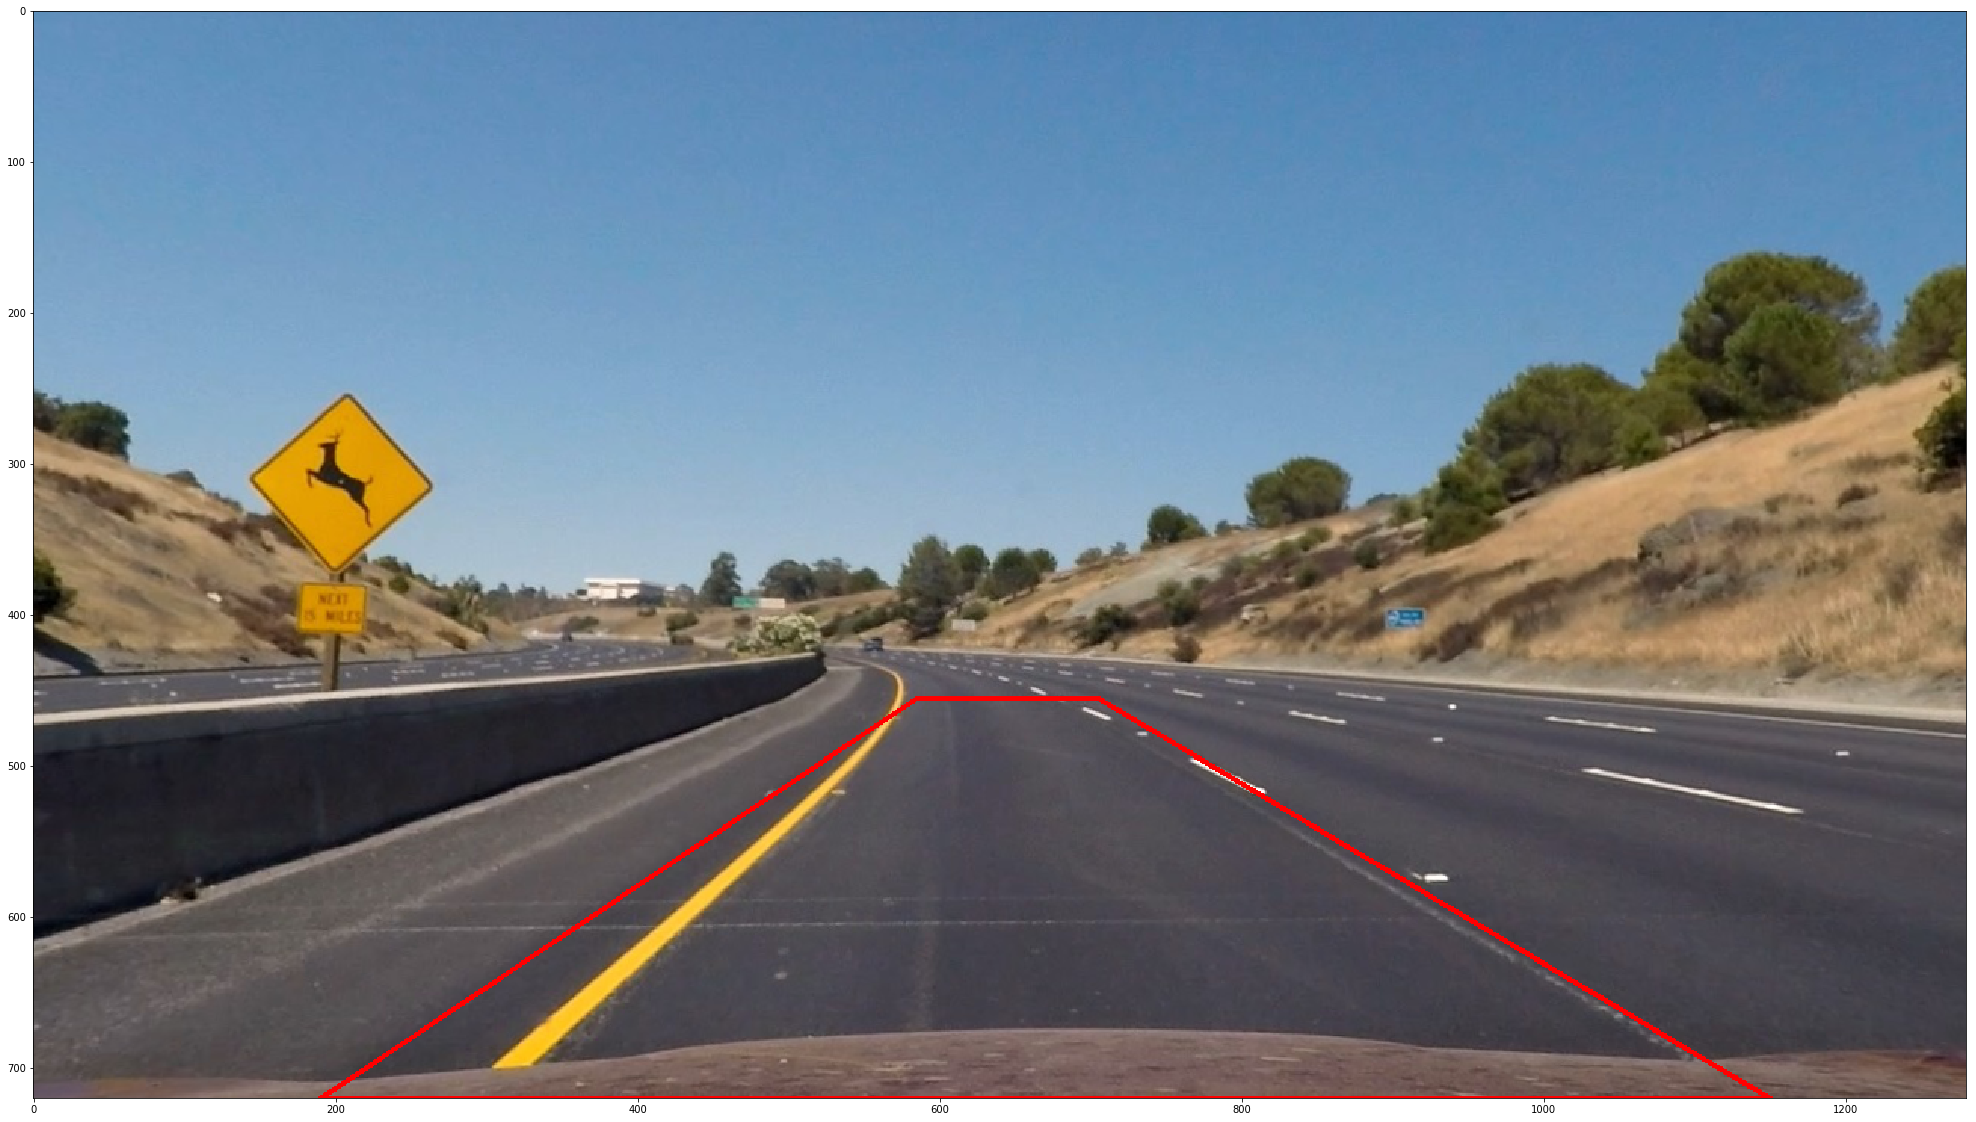

In [12]:
# Crop area to apply bird eye view
index = 0
original = cv2.cvtColor(test_images[index][1],cv2.COLOR_BGR2RGB)
undist = cv2.undistort(original, mtx, dist, None, mtx)

xSize, ySize, _ = undist.shape
copy = undist.copy()

bottomY = 720
topY = 455


left1 = (190, bottomY)
left1_x, left1_y = left1
left2 = (585, topY)
left2_x, left2_y = left2

right1 = (705, topY)
right1_x, right1_y = right1

right2 = (1150, bottomY)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

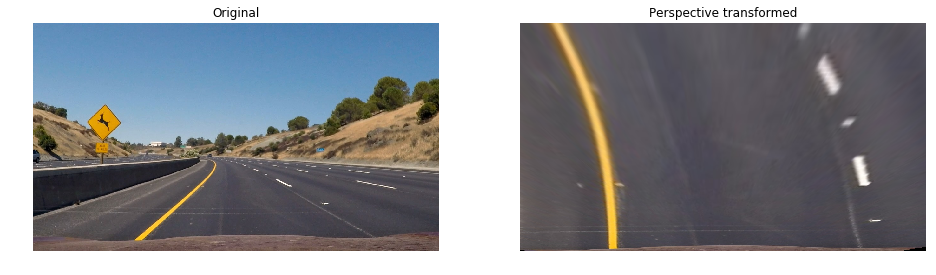

In [13]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])
img_size = (gray.shape[1], gray.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size)

show_compare_images(
    original, 'Original',
    warped, 'Perspective transformed'
)
warped = cv2.warpPerspective(undist, M, img_size)

In [14]:
def AdjustPerspective(image, M=M):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

combineAndTransform = lambda img: AdjustPerspective(combineGradients(img))

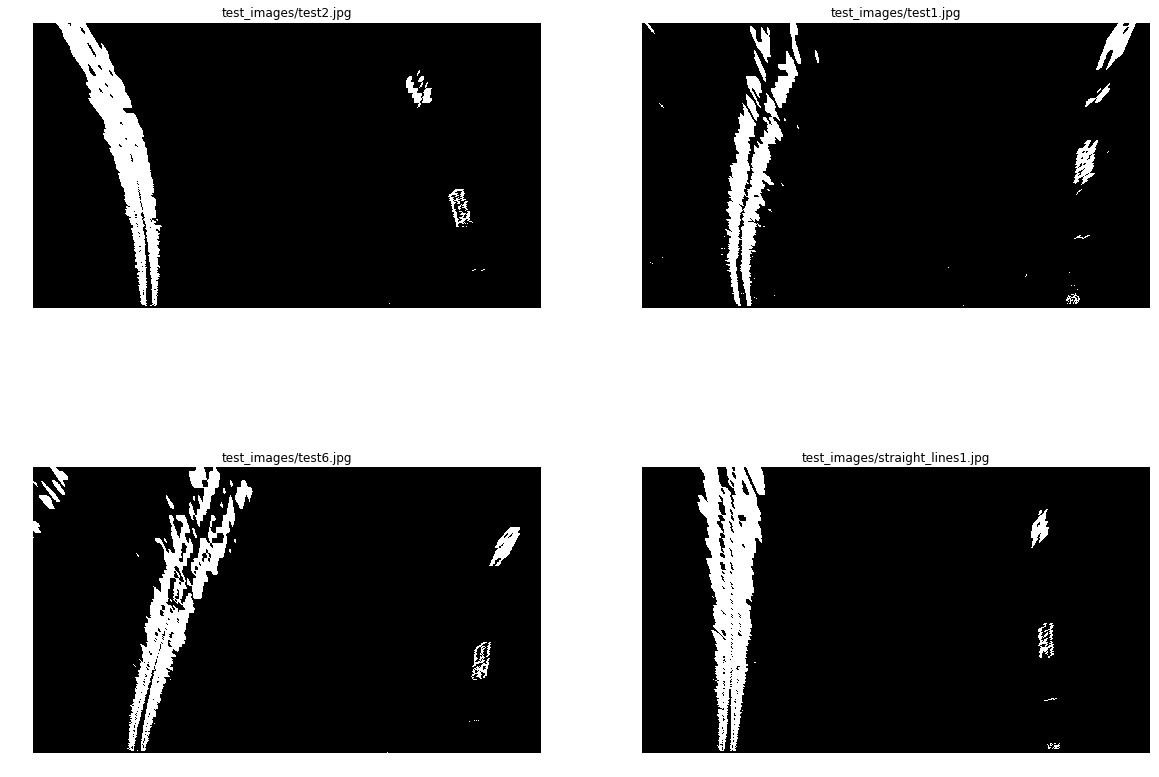

In [15]:
resultPerspective = applyActionToImages(test_images, combineAndTransform)
show_images( resultPerspective, 2, 2, (20, 15), cmap='gray')

## Finding lane lines

### Sliding Window Algorithm

In [28]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 29.8/720 # meters per pixel in y dimension
xm_per_pix = 3.5/700 # meters per pixel in x dimension

def sliding_window_polyfit(image, nwindows=9, margin=110, minpix=50):
    # Make a binary and transform image
    binary_warped = combineAndTransform(image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    left_fit_m, right_fit_m = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

### Polyfit using previous fit

In [29]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(image, left_fit_prev, right_fit_prev):
    binary_warped = combineAndTransform(image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

In [30]:
def visualizeLanes(image, ax):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_window_polyfit(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

In [31]:
def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

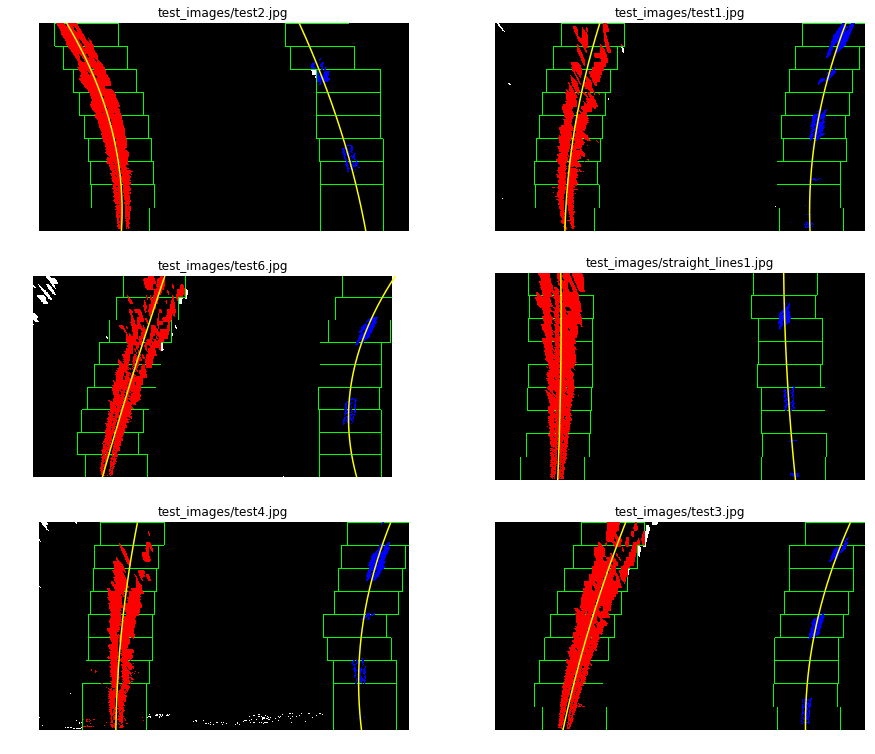

In [20]:
imagesPoly = showLaneOnImages(test_images)

### Calculate Curvature

In [21]:
def calculateCurvature(y_eval, left_fit_cr):  
    return ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imagePoly in imagesPoly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imagePoly
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))

Image : test_images/test2.jpg, Left : 0.38 km, Right : 0.90 km
Image : test_images/test1.jpg, Left : 0.86 km, Right : 0.58 km
Image : test_images/test6.jpg, Left : 4.40 km, Right : 0.26 km
Image : test_images/straight_lines1.jpg, Left : 4.47 km, Right : 2.69 km
Image : test_images/test4.jpg, Left : 1.38 km, Right : 0.47 km
Image : test_images/test3.jpg, Left : 1.42 km, Right : 0.54 km


### Warp

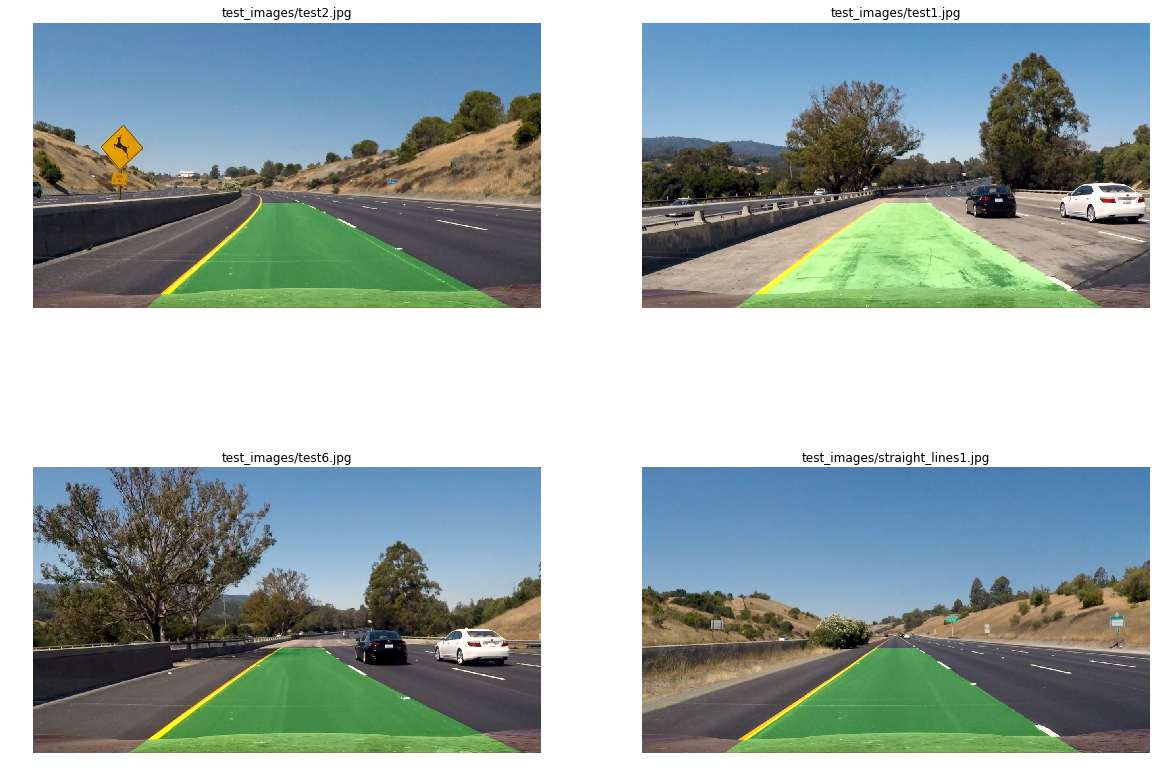

In [22]:
def drawLine(img, left_fit, right_fit):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = sliding_window_polyfit(img)
    if left_fit is not None and right_fit is not None:
        output = drawLine(img, left_fit, right_fit)
    else:
        output = img
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

resultLines = applyActionToImages(test_images, drawLaneOnImage)
show_images(resultLines, 2, 2, (20, 15), cmap='gray')

### Draw data

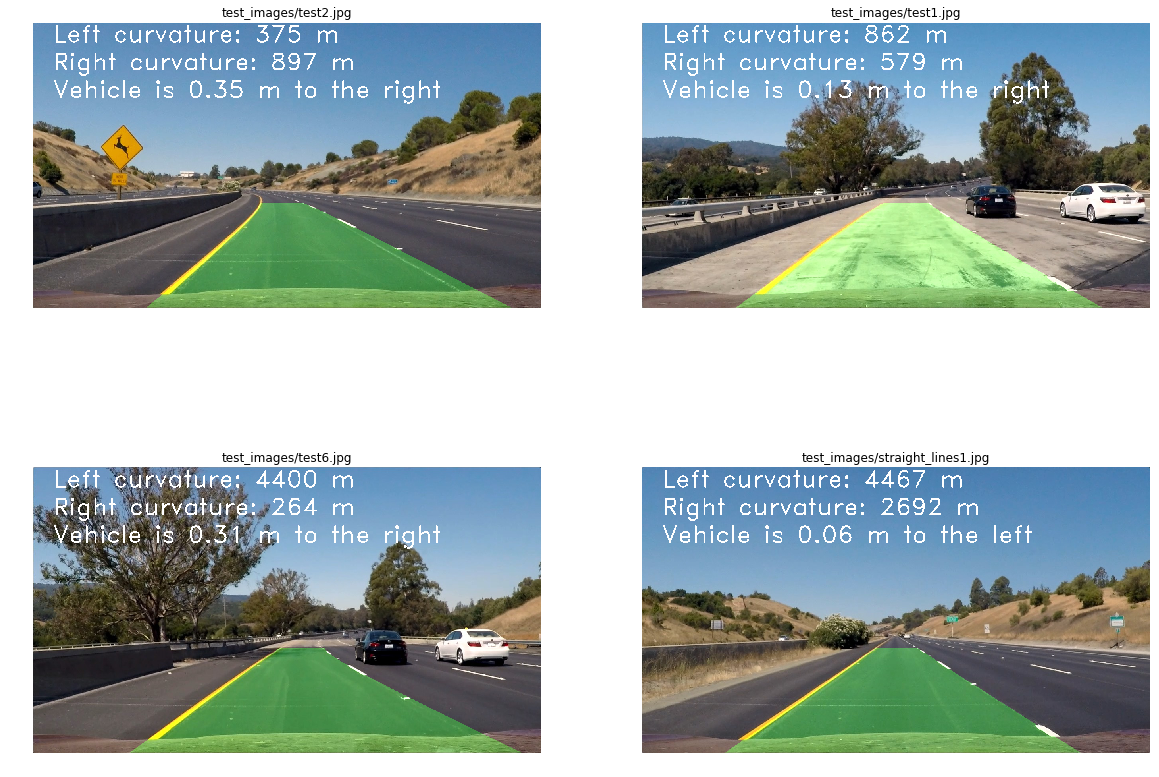

In [23]:
def pipeline(img, fontScale=2):
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = sliding_window_polyfit(img)
    if left_fit is None or right_fit is None or left_fit_m is None or right_fit_m is None:
        return img

    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m to the right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m to the left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_DUPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {}'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

resultDisplay = applyActionToImages(test_images, lambda img: cv2.cvtColor(pipeline(img), cv2.COLOR_BGR2RGB))
show_images(resultDisplay, 2, 2, (20, 15), cmap='gray')

### Create a video using the output images

In [54]:
from moviepy.editor import VideoFileClip

# Create a Line class for left and right lane lines
class Line():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = sliding_window_polyfit(img)

    if left_fit is not None and right_fit is not None and left_fit_m is not None and right_fit_m is not None:
        left_lane_object.left_fit = left_fit
        right_lane_object.right_fit = right_fit
        left_lane_object.left_fit_m = left_fit_m
        right_lane_object.right_fit_m = right_fit_m
        if left_lane_object.leftCurvature == None:
            left_lane_object.leftCurvature = calculateCurvature(yRange, left_fit_m) 
        if right_lane_object.rightCurvature == None:
            right_lane_object.rightCurvature = calculateCurvature(yRange, right_fit_m)
    else:
        left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = polyfit_using_prev_fit(img, left_lane_object.left_fit, right_lane_object.right_fit)
       
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)

    
    if leftCurvature > 10000:
        left_fit = left_lane_object.left_fit
        left_fit_m = left_lane_object.left_fit_m
        leftCurvature = left_lane_object.leftCurvature
    else:
        left_lane_object.left_fit = left_fit
        left_lane_object.left_fit_m = left_fit_m
        left_lane_object.leftCurvature = leftCurvature

    if rightCurvature > 10000:
        right_fit = right_lane_object.right_fit
        right_fit_m = right_lane_object.right_fit_m
        rightCurvature = right_lane_object.rightCurvature
    else:
        right_lane_object.right_fit = right_fit
        right_lane_object.right_fit_m = right_fit_m
        right_lane_object.rightCurvature = rightCurvature

    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

# Show line information on the image
def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m to the right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m to the left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_DUPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {}'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    myclip = VideoFileClip(inputVideo)

    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)   
        output = displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)
        return output

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

### Project Video

In [55]:
left_lane_object = Line()
right_lane_object = Line()
videoPipeline('project_video.mp4', 'output_video/project_video.mp4')

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [03:55<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 



In [57]:
left_lane_object = Line()
right_lane_object = Line()
videoPipeline('challenge_video.mp4', 'output_video/challenge_video.mp4')

[MoviePy] >>>> Building video output_video/challenge_video.mp4
[MoviePy] Writing video output_video/challenge_video.mp4


100%|██████████| 485/485 [01:19<00:00,  6.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video.mp4 

